## Introduction
Generally speaking, future market prices are unpredictable and almost random. But there is always a correlation between different assets, which is not random and probably can be used to get more accurate price evaluation, especially during crises and high volatility. In this kernel I will try to show that ML model after analysed the most influential historical data and grasped fundamental dependencies is capable enough to accurately detect anomalies in USD/RUB pricing. And based on Regression toward the mean phenomenon we can bet against those anomalies. Based on my knowledge and understanding of the markets the most significant assets to influence USD/RUB price are: government bonds, repo rates, oil, and stock indexes. Let's examine those dependencies first. 

In [ ]:
!pip install catboost sklearn shap

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from catboost import Pool
from catboost import CatBoostRegressor
from hyperopt import fmin, tpe, hp, anneal, Trials

plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')

##  Read in the first 600 rows of market data, which are in our case the latest 600 trading days or almost two and a half years.

In [3]:
main_df = pd.read_csv('market_data.csv',index_col=0)
main_df.Date = pd.to_datetime(main_df.Date,yearfirst=True)
main_df

,Date,brent,EUR_USD,emerging_markets,MOEXBC,RGBITR_yield,treas_4M,USD_repo,USD_RUB
0,2017-03-13,51.43,1.06545,36.708759,13023.33,8.34,0.728,1.16,58.7725
1,2017-03-14,51.56,1.06000,36.499207,13016.08,8.33,0.753,1.17,59.1600
2,2017-03-15,51.97,1.07255,37.451694,12957.17,8.28,0.715,1.16,58.3900
3,2017-03-16,51.74,1.07675,37.680290,13093.18,8.22,0.708,1.29,57.7900
4,2017-03-17,51.75,1.07360,37.613617,13247.03,8.21,0.708,1.31,57.2200
...,...,...,...,...,...,...,...,...,...
596,2019-08-22,59.89,1.10800,39.639999,18186.19,7.15,1.938,2.09,65.6000
597,2019-08-23,58.78,1.11348,39.049999,18058.85,7.15,1.910,2.11,65.9850
598,2019-08-26,59.16,1.10978,39.259998,18015.13,7.16,1.933,2.10,66.0700
599,2019-08-27,58.70,1.10898,39.330002,17973.86,7.17,1.943,2.09,66.4425


## Some basic exploratory Data Analysis (EDA)

In [ ]:
main_df.describe()

,brent,EUR_USD,emerging_markets,MOEXBC,RGBITR_yield,treas_4M,USD_repo,USD_RUB
count,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000
mean,64.323245,1.154990,42.371286,15155.645141,7.813045,1.709245,2.213710,61.871676
std,9.372336,0.041284,2.822193,1861.955099,0.505143,0.552593,0.593644,3.875063
min,44.770000,1.059250,36.499207,11762.240000,6.820000,0.708000,1.000000,55.705000
25%,56.980000,1.125650,39.985130,13445.230000,7.400000,1.083000,1.790000,57.900000
50%,64.270000,1.149840,42.365707,15191.330000,7.830000,1.870000,2.310000,62.505000
75%,71.880000,1.179200,44.084286,16511.380000,8.200000,2.258000,2.500000,65.490000
max,85.900000,1.251700,50.590469,19251.210000,9.100000,2.408000,4.090000,70.565000


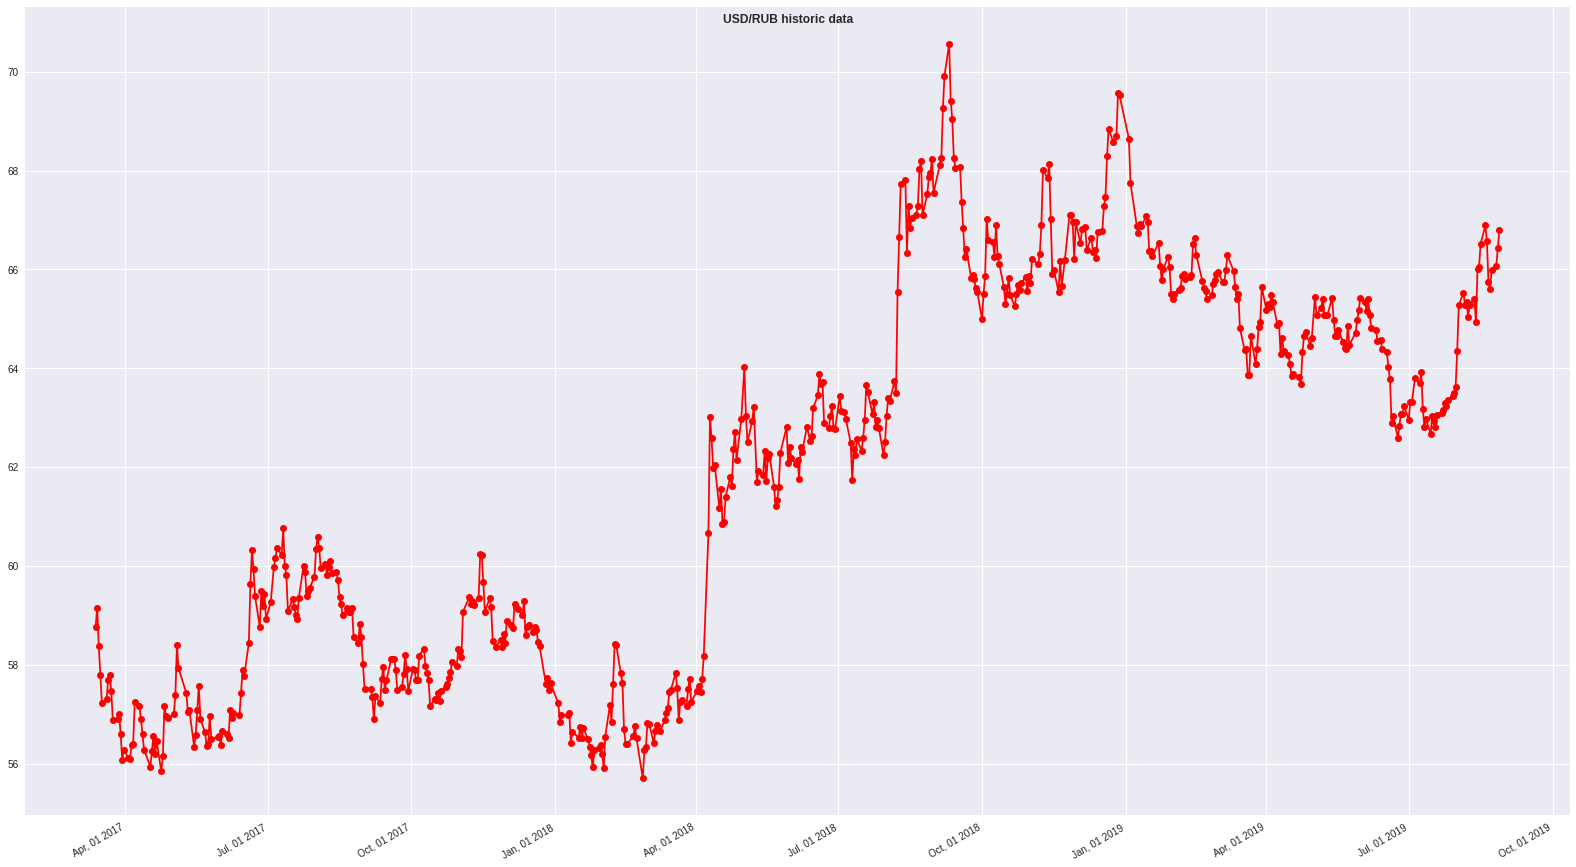

In [ ]:
fig, axs = plt.subplots(figsize=(22,12))
fig.suptitle('USD/RUB historic data', fontweight ="bold")

plt.plot_date(main_df.Date, main_df.USD_RUB, color='red',  linestyle = 'solid')
plt.gcf().autofmt_xdate()

date_format = mpl_dates.DateFormatter('%b, %d %Y')
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(date_format)

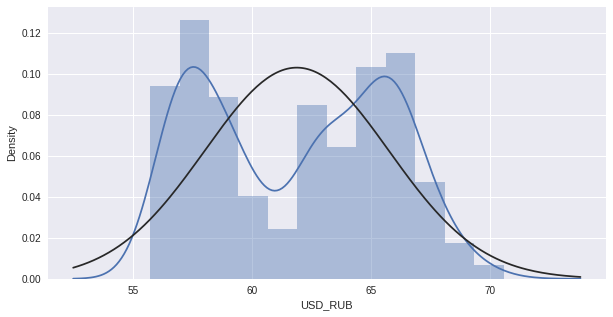

In [72]:
fig = plt.figure(figsize=(10,5))
sns.distplot(main_df['USD_RUB'],bins =12, fit=norm)

Our target USD_RUB is not normally distributed thus making prediction modeling harder. Unfortunately log transformation won't help in this case.  Let's explore correlations between our target and features. 

In [4]:
main_df.drop('Date', 1, inplace=True)
corr_df= pd.DataFrame(abs(main_df.corr().USD_RUB).sort_values(ascending=False))
corr_df.rename(columns={'USD_RUB': 'corr_original'}, inplace=True)
corr_df

,corr_original
USD_RUB,1.000000
treas_4M,0.864866
MOEXBC,0.695755
USD_repo,0.621623
RGBITR_yield,0.567899
brent,0.474665
emerging_markets,0.331401
EUR_USD,0.296095


## Feature engineering

In [9]:
main_df['yield_difference'] = main_df.RGBITR_yield - main_df.treas_4M
main_df['MOEXBC_brent_ratio'] = main_df.MOEXBC / main_df.brent 
main_df['MOEXBC_emerging_markets_ratio'] = main_df.MOEXBC / main_df.emerging_markets 

corr_df_new = pd.DataFrame(abs(main_df.corr().USD_RUB).sort_values(ascending=False))
corr_df_new.rename(columns={'USD_RUB': 'corr_df_new'}, inplace=True)
corr_df_new

,corr_df_new
USD_RUB,1.000000
treas_4M,0.864866
MOEXBC_emerging_markets_ratio,0.781827
MOEXBC,0.695755
USD_repo,0.621623
RGBITR_yield,0.567899
brent,0.474665
emerging_markets,0.331401
yield_difference,0.303372
EUR_USD,0.296095


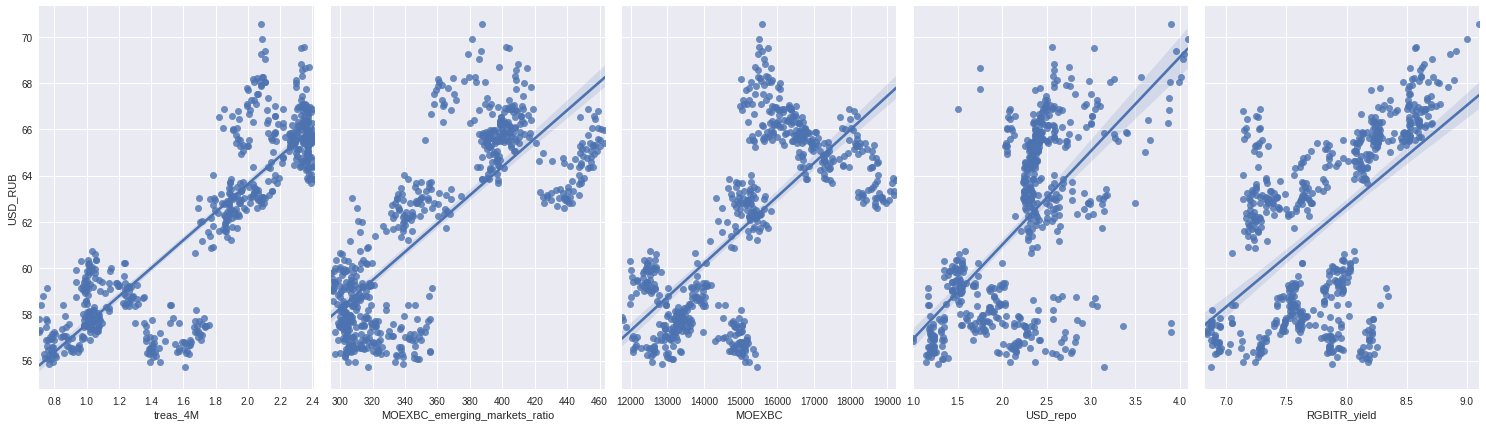

In [10]:
sns.pairplot(main_df, x_vars=['treas_4M','MOEXBC_emerging_markets_ratio','MOEXBC','USD_repo','RGBITR_yield'], y_vars='USD_RUB', height=6, aspect=0.7, kind='reg')

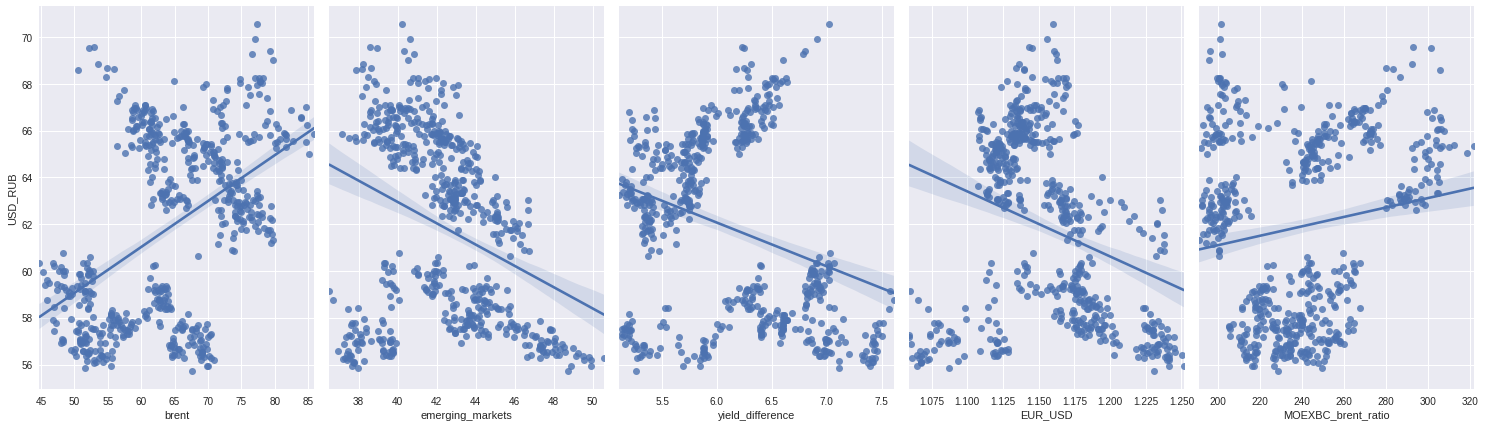

In [11]:
sns.pairplot(main_df, x_vars=['brent','emerging_markets','yield_difference','EUR_USD','MOEXBC_brent_ratio'], y_vars='USD_RUB', height=6, aspect=0.7, kind='reg')

As we can see correlation with bonds indexes, stock indexes, repo rates and oil prices are the strongest. Let's explore mutual information of features and target.

In [13]:
X = main_df.drop('USD_RUB', 1)
y =  main_df.USD_RUB

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y)
mi_scores 

treas_4M                         1.186946
MOEXBC                           1.182800
RGBITR_yield                     1.042921
MOEXBC_emerging_markets_ratio    1.006980
yield_difference                 0.994079
brent                            0.915328
USD_repo                         0.901679
EUR_USD                          0.858631
emerging_markets                 0.786613
MOEXBC_brent_ratio               0.773100
Name: MI Scores, dtype: float64

Surprisingly all features exhibit a strong enough relationship with the target. Since nonlinear relationships are possible, mutual information scores are more important

## Train/test split
It's not a time series analysis, but since the latest data usually the most interesting the latest 20% of the dataset will be a test dataset. 

In [14]:
X_train = X[(X.index < int(0.8*len(X)))]
y_train = y[(y.index < int(0.8*len(y)))]

X_test = X[(X.index >= int(0.8*len(X)))]
y_test = y[(y.index >= int(0.8*len(y)))]

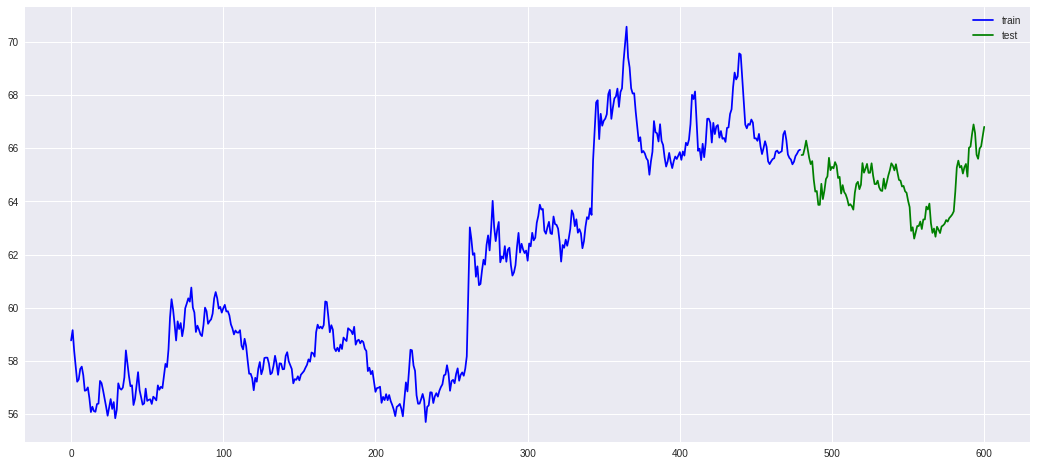

In [16]:
fig, ax = plt.subplots(figsize=(18,8))
plt.plot(y_train, color='blue', label='train')
plt.plot(y_test, color='green', label='test')
plt.legend()

##Feature-wise normalisation


In [18]:
pipeline = Pipeline([('std_scalar', StandardScaler())])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

##Let's try a few basic ML models

In [19]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted).round(3)    
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted)).round(3)         
    print('MAE:', mae)
    print('RMSE:', rmse)    
        
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted).round(3)      
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted)).round(3)           
    return mae,  rmse

In [25]:
model = Ridge(alpha = 100)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:')
print_evaluate(y_test, test_pred)
print()
print('Train set evaluation:')
print_evaluate(y_train, train_pred)

Test set evaluation:
MAE: 0.923
RMSE: 1.34

Train set evaluation:
MAE: 1.114
RMSE: 1.358


In [26]:
results_df = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, test_pred)]], columns=['Model', 'MAE',  'RMSE'])
results_df.index = np.arange(1,len(results_df)+1)
results_df

,Model,MAE,RMSE
1,Ridge Regression,0.923,1.34


In [27]:
model = RandomForestRegressor(n_estimators=1000)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:')
print_evaluate(y_test, test_pred)
print()
print('Train set evaluation:')
print_evaluate(y_train, train_pred)

Test set evaluation:
MAE: 1.245
RMSE: 1.593

Train set evaluation:
MAE: 0.117
RMSE: 0.168


In [28]:
results_df_1 = pd.DataFrame(data=[["RandomForestRegressor", *evaluate(y_test, test_pred)]], columns=['Model', 'MAE',  'RMSE'])
results_df = results_df.append(results_df_1, ignore_index=True)
results_df.index = np.arange(1,len(results_df)+1)
results_df

,Model,MAE,RMSE
1,Ridge Regression,0.923,1.340
2,RandomForestRegressor,1.245,1.593


In [29]:
early_stopping = EarlyStopping(
    min_delta=0.01, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,)

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(1),])

model.compile(optimizer=Adam(0.001), loss='mae')

history  = model.fit(X_train, y_train,validation_data=(X_test,y_test), batch_size=10, epochs = 100, callbacks=[early_stopping],verbose=0)

 Minimum validation loss(mae): 1.045


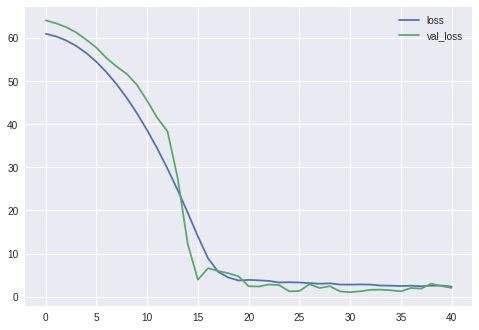

In [30]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print(f' Minimum validation loss(mae): {round(history_df.val_loss.min(),3)}')

In [31]:
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:')
print_evaluate(y_test, test_pred)
print()
print('Train set evaluation:')
print_evaluate(y_train, train_pred)

Test set evaluation:
MAE: 1.045
RMSE: 1.416

Train set evaluation:
MAE: 0.706
RMSE: 0.937


In [32]:
results_df_1 = pd.DataFrame(data=[["DNN", *evaluate(y_test, test_pred)]], columns=['Model', 'MAE',  'RMSE'])
results_df = results_df.append(results_df_1, ignore_index=True)
results_df.index = np.arange(1,len(results_df)+1)
results_df

,Model,MAE,RMSE
1,Ridge Regression,0.923,1.340
2,RandomForestRegressor,1.245,1.593
3,DNN,1.045,1.416


In [33]:
train_pool = Pool(data=X_train, label=y_train)
validation_pool = Pool(data=X_test, label=y_test)

model = CatBoostRegressor(iterations=2000, learning_rate=0.002, custom_metric=['MAE'])

model.fit(train_pool, eval_set=validation_pool, verbose= 200)

print('Model is fitted: {}'.format(model.is_fitted()))
print('Model params:\n{}'.format(model.get_params()))

0:	learn: 4.0174580	test: 3.5329356	best: 3.5329356 (0)	total: 48.6ms	remaining: 1m 37s
200:	learn: 2.8990376	test: 2.5624771	best: 2.5624771 (200)	total: 429ms	remaining: 3.84s
400:	learn: 2.1386045	test: 1.9586793	best: 1.9586793 (400)	total: 818ms	remaining: 3.26s
600:	learn: 1.6239124	test: 1.6030365	best: 1.6030365 (600)	total: 1.21s	remaining: 2.81s
800:	learn: 1.2812005	test: 1.4326645	best: 1.4326645 (800)	total: 1.59s	remaining: 2.38s
1000:	learn: 1.0494569	test: 1.3556690	best: 1.3556690 (1000)	total: 1.97s	remaining: 1.97s
1200:	learn: 0.8920079	test: 1.3208918	best: 1.3208918 (1200)	total: 2.35s	remaining: 1.56s
1400:	learn: 0.7803947	test: 1.3029274	best: 1.3027840 (1399)	total: 2.75s	remaining: 1.18s
1600:	learn: 0.6986211	test: 1.2944877	best: 1.2944604 (1599)	total: 3.13s	remaining: 781ms
1800:	learn: 0.6364801	test: 1.2846000	best: 1.2842484 (1797)	total: 3.53s	remaining: 390ms
1999:	learn: 0.5910732	test: 1.2660342	best: 1.2660109 (1998)	total: 3.91s	remaining: 0us

b

In [34]:
MAE = round(model.best_score_['validation']['MAE'],3)
RMSE =  round(model.best_score_['validation']['RMSE'],3)

results_df_2 = pd.DataFrame(data=[['CatBoost', MAE, RMSE]], columns=['Model', 'MAE',  'RMSE'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df.index = np.arange(1,len(results_df)+1)
results_df

,Model,MAE,RMSE
1,Ridge Regression,0.923,1.340
2,RandomForestRegressor,1.245,1.593
3,DNN,1.045,1.416
4,CatBoost,0.804,1.266


Since price movements are volatile and the main idea is to be good in evaluating fundamental price MAE metric (Mean Absolute Error) is preferable. CatBoost looks promising and it has a lot of potential for optimization and hyperparameters tuning.  

In [51]:
random_state=42

def catboost_opt(params, random_state=random_state, X=X_train, y=y_train):
    
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'learning_rate': params['learning_rate'],
              'l2_leaf_reg': params['l2_leaf_reg']}    
    
    model = CatBoostRegressor(**params, random_seed = random_state)
    model.fit(train_pool, eval_set=validation_pool, verbose= 0)   
    y_pred = model.predict(X_test)
     
    return metrics.mean_absolute_error(y_test, y_pred)

In [52]:
space={'n_estimators': hp.quniform('n_estimators', 1000, 3000, 20),
       'max_depth' : hp.quniform('max_depth', 2, 6, 1),
       'learning_rate': hp.loguniform('learning_rate', -7, -1),
       'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10) }

best=fmin(fn = catboost_opt, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals = 500, # maximum number of iterations         
          rstate=np.random.RandomState(random_state) # fixing random state for the reproducibility
          )

100%|██████████| 500/500 [23:59<00:00,  2.88s/it, best loss: 0.7336396039527748]


In [58]:
best

{'l2_leaf_reg': 1.7592341747746005,
 'learning_rate': 0.05346190030951248,
 'max_depth': 5.0,
 'n_estimators': 1980.0}

In [59]:
model = CatBoostRegressor(random_state=random_state, n_estimators=int(best['n_estimators']),max_depth=int(best['max_depth']),
        learning_rate=best['learning_rate'], l2_leaf_reg = best['l2_leaf_reg'],  custom_metric=['MAE'])

model.fit(train_pool, eval_set=validation_pool, verbose= 200)

print('Model is fitted: {}'.format(model.is_fitted()))
print('Model params:\n{}'.format(model.get_params()))


0:	learn: 3.8446813	test: 3.4403348	best: 3.4403348 (0)	total: 2ms	remaining: 3.95s
200:	learn: 0.3558001	test: 1.0349007	best: 1.0318070 (187)	total: 253ms	remaining: 2.24s
400:	learn: 0.2139802	test: 1.0421188	best: 1.0235493 (241)	total: 504ms	remaining: 1.98s
600:	learn: 0.1479890	test: 1.0425302	best: 1.0235493 (241)	total: 763ms	remaining: 1.75s
800:	learn: 0.1099446	test: 1.0437199	best: 1.0235493 (241)	total: 1.01s	remaining: 1.49s
1000:	learn: 0.0831661	test: 1.0460641	best: 1.0235493 (241)	total: 1.26s	remaining: 1.23s
1200:	learn: 0.0650019	test: 1.0467840	best: 1.0235493 (241)	total: 1.52s	remaining: 984ms
1400:	learn: 0.0524543	test: 1.0448755	best: 1.0235493 (241)	total: 1.77s	remaining: 731ms
1600:	learn: 0.0427305	test: 1.0424227	best: 1.0235493 (241)	total: 2.01s	remaining: 477ms
1800:	learn: 0.0349705	test: 1.0393866	best: 1.0235493 (241)	total: 2.26s	remaining: 225ms
1979:	learn: 0.0295018	test: 1.0396552	best: 1.0235493 (241)	total: 2.48s	remaining: 0us

bestTest = 

In [60]:
MAE = round(model.best_score_['validation']['MAE'],3)
print(f'Best score\nMAE = {MAE}')

Best score
MAE = 0.734


In [73]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,5,55.142673
1,4,9.575682
2,7,7.071112
3,8,6.289640
4,0,5.602434
5,9,4.744098
6,2,3.690427
7,6,3.598303
8,3,2.199501
9,1,2.086131


treas_4M and RGBITR_yield (US government bonds and Russian  government bonds) are two most important features

## Some basic quantitative analysis of the results.

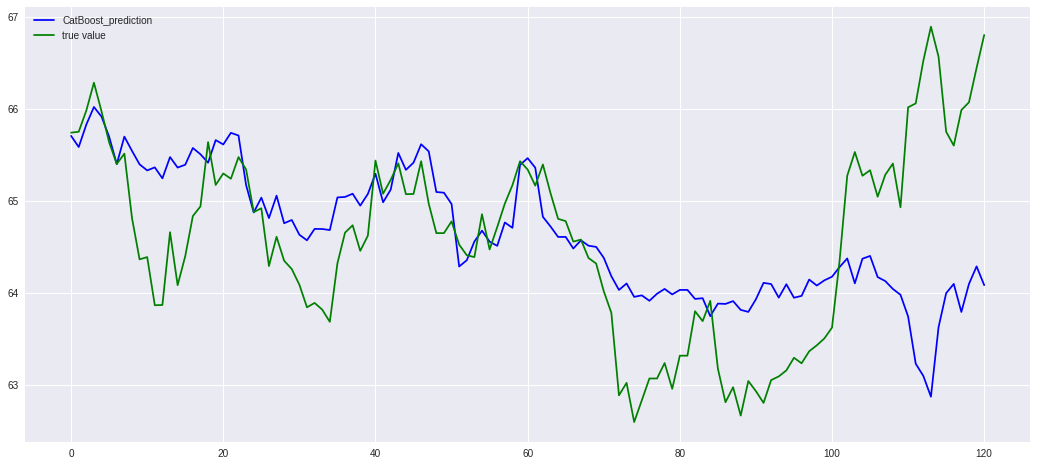

In [74]:
prediction = model.predict(X_test)

fig, ax = plt.subplots(figsize=(18,8))
plt.plot(prediction, color='blue', label='CatBoost_prediction')
plt.plot(np.array(y_test), color='green', label='true value')
plt.legend()

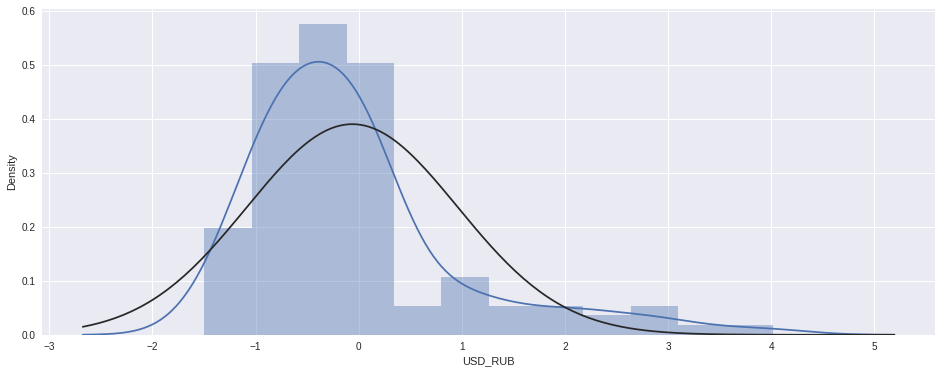

In [75]:
deviation = y_test - prediction
fig = plt.figure(figsize=(16,6))
sns.distplot(deviation,bins=12, fit=norm);

Unlike USD/RUB, prediction error has quite normal (Gaussian) distribution thus Empirical Rule can be applied.  

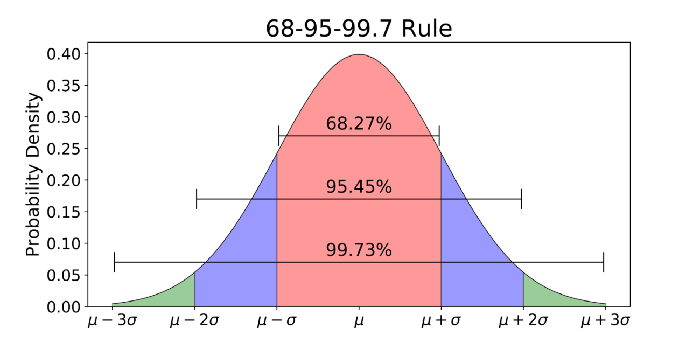

The normal distribution is commonly associated with the 68-95-99.7 rule which you can see in the image above. 68% of the data is within 1 standard deviation (σ) of the mean (μ), 95% of the data is within 2 standard deviations (σ) of the mean (μ), and 99.7% of the data is within 3 standard deviations (σ) of the mean (μ).

In [76]:
USD_mean = round(y.mean(),2)
USD_std =round(y.std(),2)

mean_error = round(deviation.mean(),2)

std_deviation =  round(deviation.std(),2)
relative_mispricing = deviation/std_deviation

Upper_limit = mean_error + 2*std_deviation
Lower_limit = mean_error - 2*std_deviation

print("USD mean value =", USD_mean) # calculated for the all cleaned dataset 
print("USD standard deviation =", USD_std) # calculated for the all cleaned dataset
print("Mean Error =",mean_error) # Mean Error of our prediction calculated for the all cleaned dataset
print("Standard deviation of the error =", std_deviation) # standard deviation of  prediction error calculated for the all cleaned dataset

USD mean value = 61.87
USD standard deviation = 3.88
Mean Error = -0.06
Standard deviation of the error = 1.03


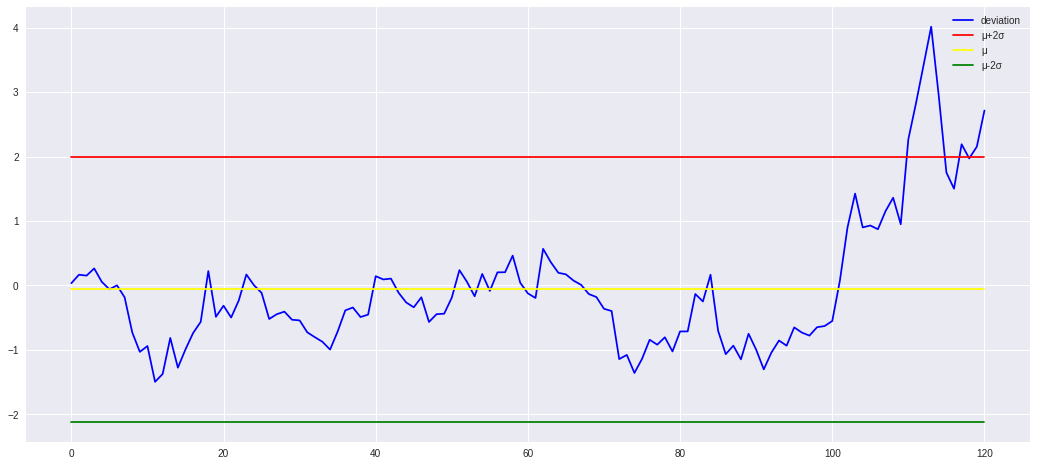

In [77]:
fig, ax = plt.subplots(figsize=(18,8))
plt.plot(np.array(deviation) , color='blue', label='deviation')
plt.plot(np.full((121, ),Upper_limit), color='red', label='μ+2σ')
plt.plot(np.full((121, ),mean_error), color='yellow', label='μ')
plt.plot(np.full((121, ),Lower_limit), color='green', label='μ-2σ')
plt.legend()

## Wrapping up
Quantitative analysis and statistical approach of assets pricing can be useful and give good results for the purposes of 'fair' baised on underlying fundamentals pricing as well as detection and evaluation of anomalys in market pricing. And even though fundamentals isn't always price movement's main driving force good understanding of them can give some adge.